In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# Read the datasets
df_ams_cc = pd.read_csv('../data/cleaned/df_ams_cc.csv')
df_weather = pd.read_csv('../data/cleaned/df_wea.csv')
df_accidents = pd.read_csv('../data/cleaned/gdf_joined.csv')



In [16]:
display(df_weather.head())
display(df_accidents.head())
display(df_ams_cc.head())

,Unnamed: 0,date,temp_C,precip_mm,wind_avg_ms,sun_hours,humidity_pct,visibility_min_m,visibility_max_m
0,24107,2017-01-01,1.6,0.6,5.3,0.0,97.0,200.0,3800.0
1,24108,2017-01-02,3.2,2.0,3.3,4.6,83.0,2800.0,32000.0
2,24109,2017-01-03,5.7,0.4,7.2,0.7,85.0,11000.0,25000.0
3,24110,2017-01-04,5.9,0.6,8.0,2.8,76.0,3900.0,22000.0
4,24111,2017-01-05,0.3,-0.1,3.0,6.2,79.0,15000.0,47000.0


,Unnamed: 0,accident_id,total_accidents,fatal_accidents,injury_accidents,damage_only_accidents,geometry_wkt,geometry,centroid,index_right,...,weekday_2020,weekday_2019,weekday_2018,weekday_2017,location_code,wkt_lng_lat,wkt_lat_lng,longitude,latitude,distance_m
0,0,1,1,0,1,0,POLYGON ((179046.73279999942 309408.8781999983...,"POLYGON ((5.728085069118202 50.77410669272724,...",POINT (179040.2349995231 309458.4569960681),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,169007.617336
1,1,2,1,0,0,1,"POLYGON ((177255.8396999985 310240.2259999998,...","POLYGON ((5.702748546852566 50.78165155046857,...",POINT (177249.3590014013 310289.8069981025),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,167790.579361
2,2,3,1,0,0,1,POLYGON ((178901.10350000113 311532.4411999993...,"POLYGON ((5.72616005741394 50.79320068551851, ...",POINT (178894.6069976456 311582.0199980425),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,166908.586421
3,3,4,1,0,1,0,POLYGON ((178656.49430000037 313910.4211000018...,"POLYGON ((5.722845762480663 50.8145856106313, ...",POINT (178649.9999999999 313960),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,164539.720943
4,4,5,2,0,2,0,"POLYGON ((176617.4726999998 313949.6506000012,...","POLYGON ((5.693918115118937 50.81501866838283,...",POINT (176610.9979999998 313999.232),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,164032.344449


,Unnamed: 0,participant_id,accident_id,accident_year,roadsegment_id,municipality,roadsegment_id.1,segment_startdate,segment_enddate,roadnumber,streetname,neighborhood,municipality.1,shape,rd_x,rd_y,longitude,latitude
0,0,NaN,20140010399,2014.0,244380021.0,Amsterdam,244380021.0,2020-12-01T00:00:00,2024-05-31T00:00:00,NaN,Klaprozenweg,Amsterdam,Amsterdam,LINESTRING (122469.24489999935 490087.15410000...,122469.2449,490087.1541,4.909244,52.397660
1,1,NaN,20140011623,2014.0,242372014.0,Amsterdam,242372014.0,2020-12-01T00:00:00,2024-05-31T00:00:00,NaN,Vijzelstraat,Amsterdam,Amsterdam,LINESTRING (121256.4354000017 486163.425799999...,121256.4354,486163.4258,4.891820,52.362323
2,2,NaN,20140011930,2014.0,253372001.0,Amsterdam,253372001.0,2021-10-01T00:00:00,NaN,010,Ringweg-Oost,Amsterdam,Amsterdam,"LINESTRING (126588.02679999918 486233.7511, 12...",126588.0268,486233.7511,4.970084,52.363257
3,3,NaN,20140014189,2014.0,241378037.0,Amsterdam,241378037.0,2020-05-01T00:00:00,2021-12-31T00:00:00,NaN,Tasmanstraat,Amsterdam,Amsterdam,LINESTRING (120583.93600000069 489379.40599999...,120583.9360,489379.4060,4.881618,52.391185
4,4,NaN,20140014197,2014.0,233376127.0,Amsterdam,233376127.0,2020-12-01T00:00:00,2024-05-31T00:00:00,NaN,Burg De Vlugtlaan,Amsterdam,Amsterdam,LINESTRING (116948.81799999997 488192.20080000...,116948.8180,488192.2008,4.828353,52.380275


## Create a basic yearly  accident trend column using accident_year


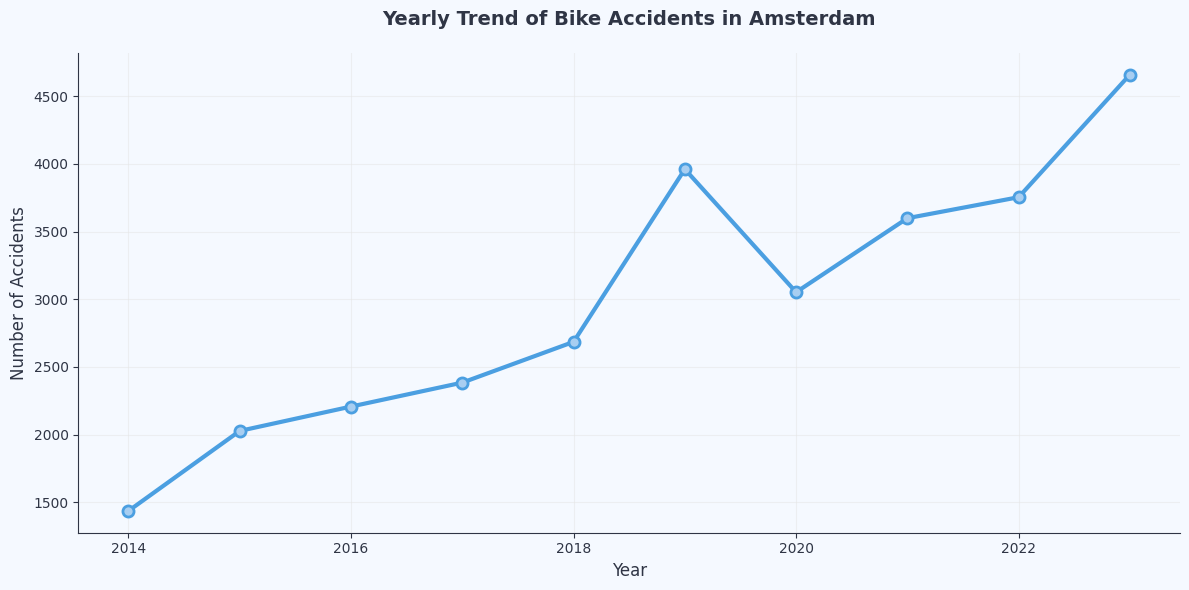

In [25]:
# Set the custom color theme that matches your presentation
custom_colors = {
    'primary_blue': '#A8CEF1',    # Light blue from the image
    'secondary_blue': '#4B9FE1',  # Darker blue for emphasis
    'background': '#F5F9FF',      # Very light blue background
    'grid': '#E5E5E5',           # Light gray for grid
    'text': '#2F3545'            # Dark navy for text
}

# Create the plot with the custom theme
plt.rcParams['figure.facecolor'] = custom_colors['background']
plt.rcParams['axes.facecolor'] = custom_colors['background']
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = custom_colors['grid']
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.alpha'] = 0.5

# Create the figure
plt.figure(figsize=(12, 6))

# Convert year and create yearly accidents count
df_ams_cc['year'] = df_ams_cc['accident_year'].astype(int)
yearly_accidents = df_ams_cc['year'].value_counts().sort_index()

# Create the plot with custom styling
ax = plt.gca()

# Plot the line with custom colors and styling
plt.plot(yearly_accidents.index, yearly_accidents.values, 
         marker='o', 
         color=custom_colors['secondary_blue'],
         linewidth=3,
         markersize=8,
         markerfacecolor=custom_colors['primary_blue'],
         markeredgecolor=custom_colors['secondary_blue'],
         markeredgewidth=2)

# Style the title and labels
plt.title('Yearly Trend of Bike Accidents in Amsterdam', 
          color=custom_colors['text'],
          pad=20,
          fontsize=14,
          fontweight='bold')
plt.xlabel('Year', color=custom_colors['text'], fontsize=12)
plt.ylabel('Number of Accidents', color=custom_colors['text'], fontsize=12)

# Style the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(custom_colors['text'])
ax.spines['bottom'].set_color(custom_colors['text'])
ax.tick_params(colors=custom_colors['text'])

# Adjust layout and display
plt.tight_layout()
plt.show()

## Spatial Analysis - Create heatmap


In [28]:
amsterdam_map = folium.Map(location=[52.3676, 4.9041],  # Amsterdam center coordinates
                          zoom_start=13,
                          tiles='CartoDB positron')

# Prepare data for heatmap
locations = df_ams_cc[['latitude', 'longitude']].values.tolist()

# Add heatmap layer
HeatMap(locations,
        radius=15,
        blur=10,
        max_zoom=13,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
        ).add_to(amsterdam_map)

# Display the map
amsterdam_map

## Hotspot Statistics

In [34]:
# Prepare the coordinates for clustering
coords = df_ams_cc[['latitude', 'longitude']].values
coords_scaled = StandardScaler().fit_transform(coords)

# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(coords_scaled)
df_ams_cc['cluster'] = db.labels_

# Analyze hotspot characteristics
hotspot_stats = df_ams_cc[df_ams_cc['cluster'] != -1].groupby('cluster').agg({
    'accident_id': 'count',
    'latitude': 'mean',
    'longitude': 'mean',
    'streetname': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'neighborhood': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
}).reset_index()

hotspot_stats.columns = ['cluster', 'accident_count', 'center_lat', 'center_lon', 'main_street', 'neighborhood']
print("\nHotspot Statistics:")
print(hotspot_stats.sort_values('accident_count', ascending=False))



Hotspot Statistics:
   cluster  accident_count  center_lat  center_lon       main_street  \
0        0           27242   52.371181    4.878375      Ringweg-West   
1        1            2390   52.306169    4.968014  Gaasperdammerweg   
3        3              64   52.368779    4.758139       Westrandweg   
6        6              27   52.279966    5.065184         Dammerweg   
5        5              21   52.296131    5.084682     Gooilandseweg   
4        4               6   52.421948    4.781445        Siciliëweg   
2        2               5   52.404131    5.033814     Uitdammerdijk   

  neighborhood  
0    Amsterdam  
1    Amsterdam  
3    Amsterdam  
6        Weesp  
5        Weesp  
4    Amsterdam  
2    Amsterdam  


## Risk Prediction Model


Risk Prediction Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00      5952

    accuracy                           1.00      5953
   macro avg       0.50      0.50      0.50      5953
weighted avg       1.00      1.00      1.00      5953



/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

AttributeError: 'Text' object has no property 'padding'

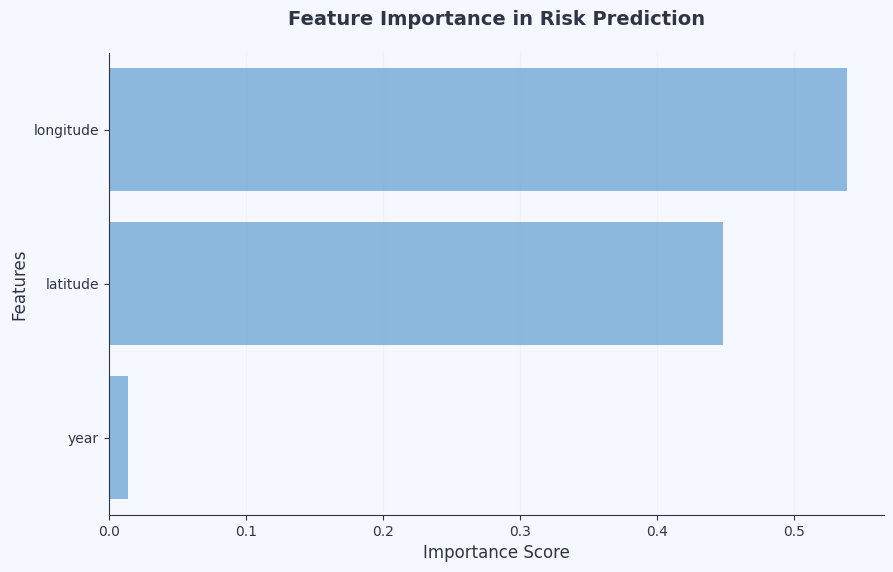

In [41]:
# Prepare features for prediction
X = df_ams_cc[['latitude', 'longitude', 'year']]

# Create target variable (1 for hotspot clusters, 0 for noise points)
y = (df_ams_cc['cluster'] != -1).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print model performance
print("\nRisk Prediction Model Performance:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)



# Create figure with custom styling
plt.figure(figsize=(10, 6), facecolor=custom_colors['background'])
ax = plt.gca()
ax.set_facecolor(custom_colors['background'])

# Create bar plot with custom colors
bars = sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance,
    color=custom_colors['secondary_blue'],
    alpha=0.7
)

# Customize the plot
plt.title('Feature Importance in Risk Prediction', 
          color=custom_colors['text'],
          pad=20,
          fontsize=14,
          fontweight='bold')

plt.xlabel('Importance Score', 
          color=custom_colors['text'],
          fontsize=12)
plt.ylabel('Features', 
          color=custom_colors['text'],
          fontsize=12)

# Style the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(custom_colors['text'])
ax.spines['bottom'].set_color(custom_colors['text'])
ax.tick_params(colors=custom_colors['text'])

# Add subtle grid
ax.grid(True, axis='x', color=custom_colors['grid'], linestyle='-', alpha=0.3)
ax.set_axisbelow(True)

# Add value labels on the bars
for i, v in enumerate(feature_importance['importance']):
    ax.text(v, i, f'{v:.3f}', 
            color=custom_colors['text'],
            va='center',
            fontsize=10,
            fontweight='light',
            padding=5)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      5952

    accuracy                           1.00      5953
   macro avg       1.00      1.00      1.00      5953
weighted avg       1.00      1.00      1.00      5953


XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      5952

    accuracy                           1.00      5953
   macro avg       1.00      1.00      1.00      5953
weighted avg       1.00      1.00      1.00      5953



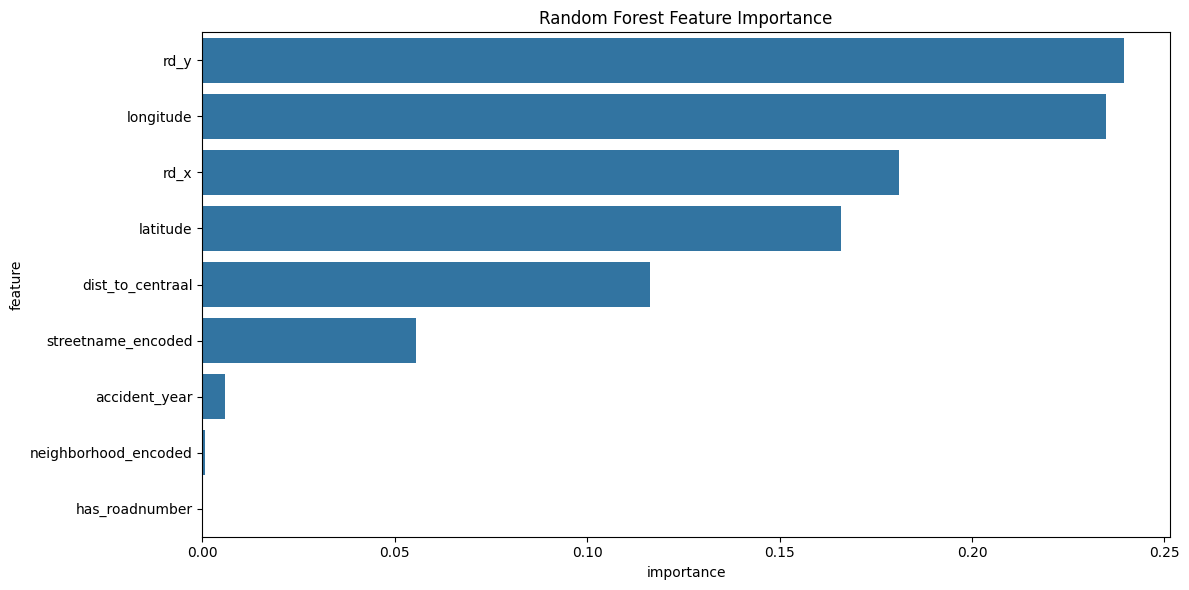

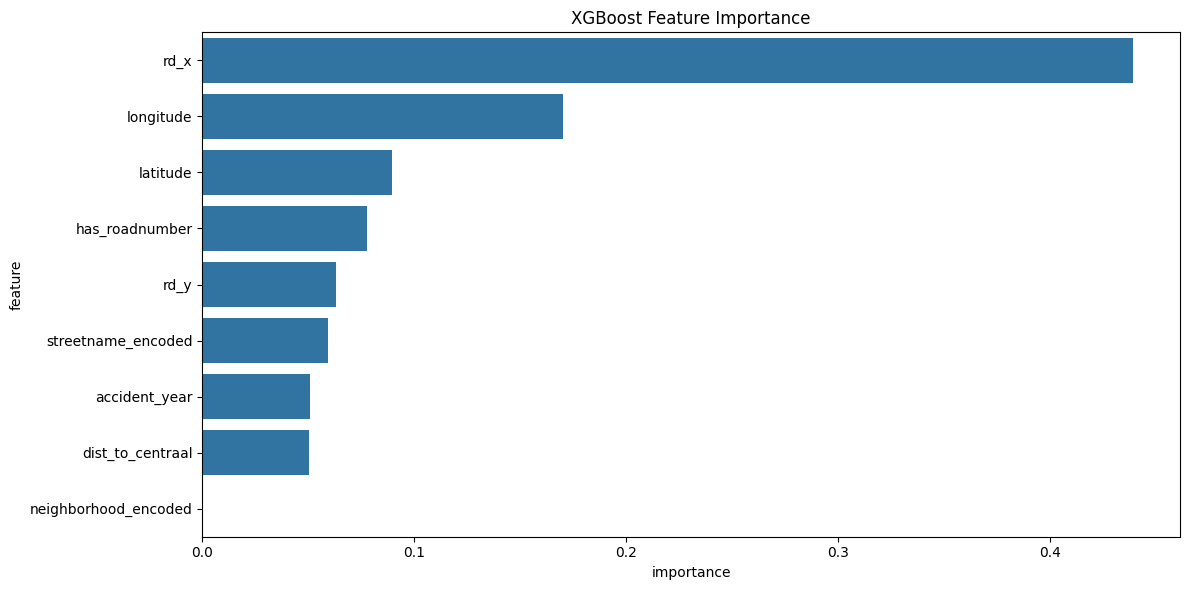


Cross-validation scores:
Random Forest: 1.000 (+/- 0.000)
XGBoost: 1.000 (+/- 0.000)


/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature

In [8]:

# Feature Engineering
# 1. Encode categorical variables
le = LabelEncoder()
df_ams_cc['streetname_encoded'] = le.fit_transform(df_ams_cc['streetname'].fillna('Unknown'))
df_ams_cc['neighborhood_encoded'] = le.fit_transform(df_ams_cc['neighborhood'].fillna('Unknown'))

# 2. Create location-based features
# Calculate distance from city center (Amsterdam Centraal)
centraal_lat, centraal_lon = 52.3791, 4.9003
df_ams_cc['dist_to_centraal'] = np.sqrt(
    (df_ams_cc['latitude'] - centraal_lat)**2 + 
    (df_ams_cc['longitude'] - centraal_lon)**2
)

# 3. Create road segment features
df_ams_cc['has_roadnumber'] = df_ams_cc['roadnumber'].notna().astype(int)

# 4. Prepare features for the model
features = [
    'latitude', 
    'longitude',
    'accident_year',
    'streetname_encoded',
    'neighborhood_encoded',
    'dist_to_centraal',
    'has_roadnumber',
    'rd_x',
    'rd_y'
]

# Prepare X (features) and y (target)
X = df_ams_cc[features].copy()

# Create target variable using DBSCAN clustering

coords = df_ams_cc[['latitude', 'longitude']].values
coords_scaled = StandardScaler().fit_transform(coords)
db = DBSCAN(eps=0.3, min_samples=5).fit(coords_scaled)
y = (db.labels_ != -1).astype(int)  # 1 for hotspot, 0 for non-hotspot

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train multiple models
# 1. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 2. XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Evaluate models
print("Random Forest Model Performance:")
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))

print("\nXGBoost Model Performance:")
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_pred))

# Feature Importance Analysis
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rf_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=xgb_importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Cross-validation scores
cv_scores_rf = cross_val_score(rf_model, X_scaled, y, cv=5)
cv_scores_xgb = cross_val_score(xgb_model, X_scaled, y, cv=5)

print("\nCross-validation scores:")
print(f"Random Forest: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")
print(f"XGBoost: {cv_scores_xgb.mean():.3f} (+/- {cv_scores_xgb.std() * 2:.3f})")

# Create risk prediction map
def predict_risk_for_location(model, location_features):
    return model.predict_proba(location_features)[0][1]

# Create a grid of points over Amsterdam
lat_range = np.linspace(df_ams_cc['latitude'].min(), df_ams_cc['latitude'].max(), 50)
lon_range = np.linspace(df_ams_cc['longitude'].min(), df_ams_cc['longitude'].max(), 50)

# Calculate risk for each point using the best performing model
best_model = rf_model if cv_scores_rf.mean() > cv_scores_xgb.mean() else xgb_model
risk_points = []

for lat in lat_range:
    for lon in lon_range:
        # Create feature vector for this location
        loc_features = pd.DataFrame({
            'latitude': [lat],
            'longitude': [lon],
            'accident_year': [df_ams_cc['accident_year'].mean()],
            'streetname_encoded': [0],  # default values
            'neighborhood_encoded': [0],
            'dist_to_centraal': [np.sqrt((lat - centraal_lat)**2 + (lon - centraal_lon)**2)],
            'has_roadnumber': [0],
            'rd_x': [0],  # You might want to calculate these properly
            'rd_y': [0]
        })
        
        # Scale the features
        loc_features_scaled = scaler.transform(loc_features)
        risk = predict_risk_for_location(best_model, loc_features_scaled)
        risk_points.append([lat, lon, risk])

# Create risk heatmap
import folium
from folium.plugins import HeatMap

risk_map = folium.Map(location=[52.3676, 4.9041], zoom_start=13)
HeatMap(risk_points).add_to(risk_map)

# Add title
title_html = '''
             <h3 align="center" style="font-size:16px">
             <b>Predicted Risk Levels for Bike Accidents</b>
             </h3>
             '''
risk_map.get_root().html.add_child(folium.Element(title_html))

risk_map